# 1.0 Ensemble Learning 

In [ ]:
!pip install --upgrade scikit-learn

## 1.1 Introduction

Suppose you ask a complex question to thousands of random people, then aggregate their answers. In many cases you will find that this aggregated answer is better than
an expert’s answer. This is called the [wisdom of the crowd](https://en.wikipedia.org/wiki/The_Wisdom_of_Crowds). Similarly, if you aggregate
the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an **ensemble**; thus, this technique is called **Ensemble Learning**, and an Ensemble Learning algorithm is called an Ensemble method.

For example, you can train a group of **Decision Tree classifiers**, each on a different random subset of the training set. To make predictions, you just obtain the predictions of all individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a **Random Forest**, and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today. In fact, the winning solutions in Machine Learning competitions often involve several Ensemble methods (most famously in the [Netflix Prize competition](https://netflixprize.com/)).

In this lesson we will discuss the most popular Ensemble methods, including **bagging**, **boosting**, **stacking**, and a few others. We will also explore **Random Forests**.

## 1.2 Voting Classifiers

Suppose you have trained a few classifiers, each one achieving about 80% accuracy. You may have a **Logistic Regression classifier**, an **SVM classifier**, a **Random Forest classifier**, a **K-Nearest Neighbors classifier**, and perhaps a few more.

<img width="600" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1kfNWez7jD10dw0RAfy_ym3npEZSys1D4">

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a **hard voting classifier**.

<img width="600" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=105KQ4RnrkWaMyYiVORvnVIMBApt7aAsc">

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there are a sufficient number of weak learners and they are sufficiently diverse.

How is this possible? The following analogy can help shed some light on this mystery. Suppose you have a slightly biased coin that has a 51% chance of coming up heads, and 49% chance of coming up tails. If you toss it 1,000 times you will generally get more or less 510 heads and 490 tails, and hence a majority of heads. If you do the math, you will find that the probability of obtaining a majority of heads after 1,000 tosses is close to 75%. The more you toss the coin, the higher the probability (e.g., with 10,000 tosses, the probability climbs over 97%). This is due to the [law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers): as you keep tossing the coin, the ratio of heads gets closer and closer to the
probability of heads (51%). Figure below shows 10 series of biased coin tosses. You can see that as the number of tosses increases, the ratio of heads approaches 51%. Eventually all 10 series end up so close to 51% that they are consistently above 50%.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# suppose you have a slightly biased coin
heads_proba = 0.51

# seed
np.random.seed(42)

# 10 series of biased coin tosses (10.000)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)

# cumulative heads ratio for each series
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

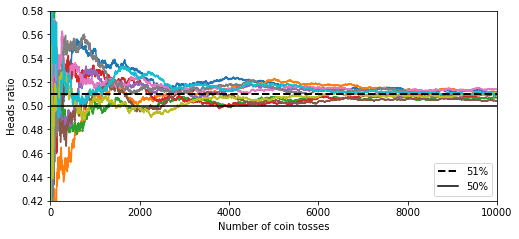

In [ ]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

Similarly, suppose you build an ensemble containing 1,000 classifiers that are individually correct only 51% of the time (barely better than random guessing. If you predict the majority voted class, you can hope for up to 75% accuracy! However, this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case since they are trained on the same data. They are likely to make the same types of errors, so there will be many majority votes for the wrong class, reducing the ensemble’s accuracy.

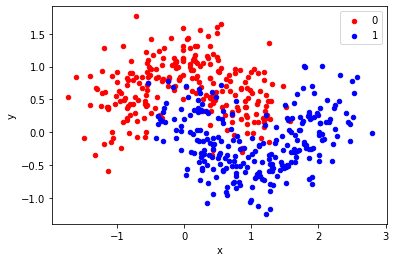

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import pandas as pd

# generate 2d classification dataset
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

# scatter plot, dots colored by class value
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [ ]:
# split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

The following code creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifiers.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# create classifiers
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

# hard voting
voting_clf_hard = VotingClassifier(
    estimators=[('lr', log_clf), 
                ('rf', rnd_clf),
                ('svc', svm_clf)],
    voting='hard')

# training all models
for clf in (log_clf, rnd_clf, svm_clf, voting_clf_hard):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.88
SVC 0.87
VotingClassifier 0.87


If all classifiers are able to estimate class probabilities (i.e., they have a pre **dict_proba()** method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called soft voting. It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All you need to do is replace **voting="hard"** with **voting="soft"** and ensure that all classifiers can estimate class probabilities. This is not the case of the SVC class by default, so you need to set its probability hyperparameter
to **True** (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a **predict_proba()** method).

In [ ]:
# crate classifiers
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

# soft voting
voting_clf_hard = VotingClassifier(
    estimators=[('lr', log_clf), 
                ('rf', rnd_clf),
                ('svc', svm_clf)],
    voting='soft')

# training all models
for clf in (log_clf, rnd_clf, svm_clf, voting_clf_hard):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.88
SVC 0.87
VotingClassifier 0.89


# 2.0 Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. Another approach is to use the **same training algorithm for every predictor**, but to train them on **different random subsets** of the training set. When sampling is performed **with replacement**, this method is called **bagging** (short for **bootstrap aggregating**). When sampling is performed **without replacement**, it is called **pasting**.


In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor. This sampling and training process is represented in Figure below.

<img width="600" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1LsFkQ-q9MHxNwb5Y2z_jsfSGq8EAVe5T">


Once all predictors are trained, the ensemble can make a prediction for a new
instance by simply aggregating the predictions of all predictors. The aggregation function is typically the statistical mode (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression. **Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance.** Generally, the net result is that the
ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.

As you can see in Figure above, predictors can all be trained in **parallel**, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons why bagging and pasting are such popular methods: they scale very well.

## 2.1 Bagging and Pasting in Scikit-Learn

Scikit-Learn offers a simple API for both bagging and pasting with the [BaggingClassifier class](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) (or BaggingRegressor for regression). The following code trains an ensemble of 500 Decision Tree classifiers, each trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set **bootstrap=False**). The **n_jobs** parameter tells Scikit-Learn the number of CPU cores to use for training and predictions (–1 tells Scikit-Learn to use all available cores).

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# instantiate a bagging object (model,size,samples,bootstrap,rnd)
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), 
                            n_estimators=500,
                            max_samples=100, 
                            bootstrap=True, 
                            random_state=42)
# training the  bagging model
bag_clf.fit(X_train, y_train)

# instantiate a pasting object (model,size,samples,bootstrap,rnd)
pas_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), 
                            n_estimators=500,
                            max_samples=100, 
                            bootstrap=False, 
                            random_state=42)
# training the  pasting model
pas_clf.fit(X_train, y_train)

# instantiate a Decision Tree classifier
tree_clf = DecisionTreeClassifier(random_state=42)

# train the Decision Tree model
tree_clf.fit(X_train, y_train)

# predict
y_pred_bag = bag_clf.predict(X_test)
y_pred_pas = pas_clf.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

print("Accuracy.bagging: {0:.2f}".format(accuracy_score(y_test, y_pred_bag)))
print("Accuracy.pasting: {0:.2f}".format(accuracy_score(y_test, y_pred_pas)))
print("Accuracy.decision_tree: {0:.2f}".format(accuracy_score(y_test, y_pred_tree)))

Accuracy.bagging: 0.90
Accuracy.pasting: 0.91
Accuracy.decision_tree: 0.82


In [ ]:
# source: https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

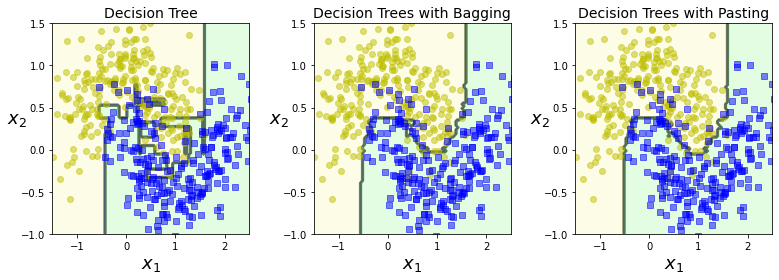

In [ ]:
plt.figure(figsize=(11,4))
plt.subplot(131)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(132)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.subplot(133)
plot_decision_boundary(pas_clf, X, y)
plt.title("Decision Trees with Pasting", fontsize=14)
plt.tight_layout()
plt.show()

You can compare the decision boundary of a single Decision Tree with the decision boundary of a bagging ensemble of 500 trees (from the preceding code), bothtrained on the moons dataset. As you can see, the ensemble’s  predictions will likely generalize much better than the single Decision Tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular).

Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting, but this also means that predictors end up being less correlated so the ensemble’s variance is reduced. **Overall, bagging often results in better models, which explains why it is generally preferred**. However, if you have spare time and CPU power you can use crossvalidation to evaluate both bagging and pasting and select the one that works best.

## 2.2 Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default a **BaggingClassifier** samples *m* training instances with replacement (**bootstrap=True**), where *m* is the size of the training set. This means that only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances that are not
sampled are called **out-of-bag (oob)** instances. Note that they are not the same 37% for all predictors.

> If there are *m* rows in the training data set. Then, the probability of not picking a row in a random draw is:
>
>$
\displaystyle 1 - \frac{1}{m}
$
>
>Using sampling-with-replacement the probability of not picking m rows in random draws is:
>
>$
\displaystyle (1 - \frac{1}{m})^m
$
>
>which in the limit of large m becomes equal to:
>
>$
\displaystyle \lim_{m\to\infty}(1 - \frac{1}{m})^m = e^{-1} = 0.3678
$


Since a predictor never sees the **oob** instances during training, it can be evaluated on these instances, without the need for a separate validation set. You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.

In Scikit-Learn, you can set **oob_score=True** when creating a **BaggingClassifier** to request an automatic oob evaluation after training. The following code demonstrates this. The resulting evaluation score is available through the **oob_score_** variable.

In [ ]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), 
                            n_estimators=500,
                            bootstrap=True, 
                            oob_score=True, 
                            random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.91

According to this **oob** evaluation, this **BaggingClassifier** is likely to achieve about 90.75% accuracy on the test set.

## 2.3 Random Forest

### 2.3.1 Introduction


As we have discussed, a [Random Forest](https://ieeexplore.ieee.org/abstract/document/598994) is an ensemble of Decision Trees, **generally trained via the bagging** method (or sometimes pasting), typically with **max_samples = 1.0**
set to the size of the training set. Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, you can instead use the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class, which is more convenient and optimized for Decision Trees (similarly, there is a [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) class for regression tasks). 

The following code trains a Random Forest classifier with:
- 500 trees
- Each ones limited to maximum 16 nodes
- Using all available CPU cores

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest using BaggingClassifier
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_features="auto", 
                                                   max_leaf_nodes=16, 
                                                   random_state=42),
                            n_estimators=500, 
                            max_samples=1.0, 
                            bootstrap=True, 
                            random_state=42)
# Predict
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

# Random Forest using RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500,
                                 max_leaf_nodes=16, 
                                 random_state=42)
rnd_clf.fit(X_train, y_train)

# Predict
y_pred_rf = rnd_clf.predict(X_test)

# almost identical predictions
np.sum(y_pred == y_pred_rf) / len(y_pred)  

1.0

With a few exceptions, a **RandomForestClassifier** has all the hyperparameters of a **DecisionTreeClassifier** (to control how trees are grown), plus all the hyperparameters of a **BaggingClassifier** to control the ensemble itself.

The Random Forest algorithm can introduces extra randomness when growing trees;
instead of searching for the very best feature when splitting a node, it
searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a **higher bias for a lower variance**, generally yielding an overall better model. The following **BaggingClassifier** is roughly equivalent to the previous RandomForestClassifier:

In [ ]:
# Random Forest using BaggingClassifier
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_features="auto",
                                                   #added this hyperparameter
                                                   splitter="random",
                                                   max_leaf_nodes=16, 
                                                   random_state=42),
                            n_estimators=500, 
                            max_samples=1.0, 
                            bootstrap=True, 
                            random_state=42)
# Predict
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

# Random Forest using RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500,
                                 max_leaf_nodes=16, 
                                 random_state=42)
rnd_clf.fit(X_train, y_train)

# Predict
y_pred_rf = rnd_clf.predict(X_test)

# almost identical predictions
np.sum(y_pred == y_pred_rf) / len(y_pred)  

0.96

### 2.3.2 Feature Importance

Yet another great quality of Random Forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a **feature’s importance** by looking at:
- how much the tree nodes that use that feature reduce impurity on average
(across all trees in the forest). 

More precisely, it is a weighted average, where each
node’s weight is equal to the number of training samples that are associated with it. **Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1**. You can access the result using the **feature_importances_** variable. 

For example, the following code trains a RandomForestClassifier on the iris dataset and outputs each feature’s importance. It seems that the most important features are the petal length (44%) and width (42%), while sepal length and width are rather unimportant in comparison (11% and 2%, respectively).

In [ ]:
from sklearn.datasets import load_iris
#load dataset
iris = load_iris()
# instantiate the model
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
# training
rnd_clf.fit(iris["data"], iris["target"])
# find the feature importance
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


Similarly, if you train a Random Forest classifier on the MNIST dataset and plot each pixel’s importance, you get the image below:

In [ ]:
from sklearn.datasets import fetch_openml

# load and pre-processing the dataset
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

# create the random forest model
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

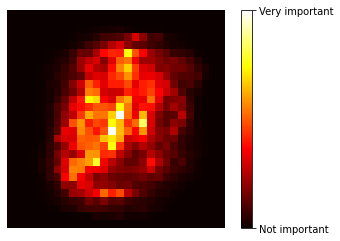

In [ ]:
import matplotlib as mpl

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

# reshape all pixels to a square (28,28)
plot_digit(rnd_clf.feature_importances_)

# define min, max values
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

### 2.3.3 Extra-trees


When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). It is possible to make
trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do).

A forest of such extremely random trees is called an **Extremely Randomized Trees** ensemble (or **Extra-Trees** for short). Once again, this technique trades more bias for
a lower variance. It also makes Extra-Trees much faster to train than regular Random Forests, because finding the best possible threshold for each feature at every node is
one of the most time-consuming tasks of growing a tree.
You can create an Extra-Trees classifier using Scikit-Learn’s [ExtraTreesClassifier class](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier). Its API is identical to the [RandomForestClassifier class](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Similarly, the Extra
TreesRegressor class has the same API as the RandomForestRegressor class.

It is hard to tell in advance whether a RandomForestClassifier
will perform better or worse than an ExtraTreesClassifier. Generally, the only way to know is to try both and compare them using cross-validation (tuning the hyperparameters using grid search).

### 2.4 Case study using bagging

### 2.4.1 Dataset description



We'll be looking at individual income in the United States. The **data** is from the **1994 census**, and contains information on an individual's **marital status**, **age**, **type of work**, and more. The **target column**, or what we want to predict, is whether individuals make less than or equal to 50k a year, or more than **50k a year**.

You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Adult).

Let's take the following steps:

1. Load Libraries
2. Get data, including EDA
3. Clean, prepare and manipulate Data (feature engineering)
4. Modeling (train and test)
5. Algorithm Tuning
6. Finalizing the Model


### 2.4.2 Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import plot_tree
import joblib

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

# Rich visual representation of estimators (new 0.23.2)
from sklearn import set_config
set_config(display='diagram')

from IPython.display import HTML

from sklearn.ensemble import RandomForestClassifier

### 2.4.3 Get data & EDA

#### 2.4.3.1 Import the dataset

In [ ]:
# columns used 
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
           'marital_status', 'occupation', 'relationship', 'race', 
           'sex','capital_gain', 'capital_loss', 'hours_per_week',
           'native_country','high_income']
# importing the dataset
income = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                   header=None,
                   names=columns)
income.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### 2.4.4  Clean, prepare and manipulate Data (feature engineering)

This dataset contains a mix of **categorical (9 columns)** and **numerical (6 columns)** independent variables which as we know will need to pre-processed in different ways and separately.

This means that initially they’ll have to go through **separate pipelines** to be pre-processed appropriately and then we’ll combine them together. So the first step in both pipelines would have to be to extract the appropriate columns that need to be pushed down for pre-processing.

#### 2.4.4.1 Removal duplications

In [ ]:
# There are duplicated rows
income.duplicated().sum()

24

In [ ]:
# Delete duplicated rows
income.drop_duplicates(inplace=True)
income.duplicated().sum()

0

#### 2.4.4.2 Removal Outliers

In [ ]:
# Verify if columns[int64] has outliers (with data leakage!!!!!!!)

# data
x = income.select_dtypes("int64")

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

print("Income shape [original]: {}".format(income.shape))
print("Income shape [outlier removal]: {}".format(income.loc[mask,:].shape))

# income with outliner
income_w = income.loc[mask,:].copy()
income_w.head()

Income shape [original]: (32537, 15)
Income shape [outlier removal]: (30977, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K


#### 2.4.4.3 Encoding target variable

If a categorical target variable needs to be encoded for a classification predictive modeling problem, then the [LabelEncoder class](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) can be used.

In [ ]:
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transoform y_train
income_w["high_income"] = le.fit_transform(income_w.high_income)

In [ ]:
le.classes_

array([' <=50K', ' >50K'], dtype=object)

In [ ]:
income_w.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,0


### 2.4.5 Pipeline 

#### 2.4.5.1 Column extractor

In [ ]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self.feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self.feature_names ]

#### 2.4.5.2 Categorical transformation

In [ ]:
# Handling categorical features 
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
  # Class constructor method that takes one boolean as its argument
  def __init__(self, new_features=True):
    self.new_features = new_features
    self.colnames = None

  #Return self nothing else to do here    
  def fit( self, X, y = None ):
    return self 

  def get_feature_names(self):
        return self.colnames.tolist()

  # Transformer method we wrote for this transformer 
  def transform(self, X , y = None ):
    df = X.copy()

    # customize feature?
    # how can I identify this one? EDA!!!!
    if self.new_features: 
      
      # minimize the cardinality of native_country feature
      df.loc[df['native_country']!=' United-States','native_country'] = 'non_usa' 

      # replace ? with Unknown
      edit_cols = ['native_country','occupation','workclass']
      for col in edit_cols:
        df.loc[df[col] == ' ?', col] = 'unknown'

      # decrease the cardinality of education feature
      hs_grad = [' HS-grad',' 11th',' 10th',' 9th',' 12th']
      elementary = [' 1st-4th',' 5th-6th',' 7th-8th']
      # replace
      df['education'].replace(to_replace = hs_grad,value = 'HS-grad',inplace = True)
      df['education'].replace(to_replace = elementary,value = 'elementary_school',inplace = True)

      # adjust marital_status feature
      married= [' Married-spouse-absent',' Married-civ-spouse',' Married-AF-spouse']
      separated = [' Separated',' Divorced']
      # replace 
      df['marital_status'].replace(to_replace = married ,value = 'Married',inplace = True)
      df['marital_status'].replace(to_replace = separated,value = 'Separated',inplace = True)

      # adjust workclass feature
      self_employed = [' Self-emp-not-inc',' Self-emp-inc']
      govt_employees = [' Local-gov',' State-gov',' Federal-gov']
      # replace elements in list.
      df['workclass'].replace(to_replace = self_employed ,value = 'Self_employed',inplace = True)
      df['workclass'].replace(to_replace = govt_employees,value = 'Govt_employees',inplace = True)

    # update column names
    self.colnames = df.columns      
  
    return df

##### 2.5.5.2.1 Evaluate

In [ ]:
# 
# for validation purposes
#
model = FeatureSelector(income_w.select_dtypes("object").columns.to_list())
df = model.fit_transform(income_w)
df.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba
5,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States
6,Private,9th,Married-spouse-absent,Other-service,Not-in-family,Black,Female,Jamaica


In [ ]:
# 
# for validation purposes
#
model = CategoricalTransformer(new_features=True)
df_cat = model.fit_transform(df)
df_cat.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country
1,Self_employed,Bachelors,Married,Exec-managerial,Husband,White,Male,United-States
3,Private,HS-grad,Married,Handlers-cleaners,Husband,Black,Male,United-States
4,Private,Bachelors,Married,Prof-specialty,Wife,Black,Female,non_usa
5,Private,Masters,Married,Exec-managerial,Wife,White,Female,United-States
6,Private,HS-grad,Married,Other-service,Not-in-family,Black,Female,non_usa


In [ ]:
# check the cardinality before and after transformation
income_w.select_dtypes("object").apply(pd.Series.nunique)

workclass          9
education         16
marital_status     7
occupation        15
relationship       6
race               5
sex                2
native_country    41
dtype: int64

In [ ]:
# check the cardinality before and after transformation
df_cat.apply(pd.Series.nunique)

workclass          6
education         10
marital_status     4
occupation        15
relationship       6
race               5
sex                2
native_country     2
dtype: int64

#### 2.4.5.3 Numerical transformation

In [ ]:
# transform numerical features
class NumericalTransformer( BaseEstimator, TransformerMixin ):
  # Class constructor method that takes a model parameter as its argument
  # model 0: minmax
  # model 1: standard
  # model 2: without scaler
  def __init__(self, model = 0):
    self.model = model
    self.colnames = None

  #Return self nothing else to do here    
  def fit( self, X, y = None ):
    return self

  # return columns names after transformation
  def get_feature_names(self):
        return self.colnames 
        
  #Transformer method we wrote for this transformer 
  def transform(self, X , y = None ):
    df = X.copy()
    
    # update columns name
    self.colnames = df.columns.tolist()
    
    # minmax
    if self.model == 0: 
      scaler = MinMaxScaler()
      # transform data
      df = scaler.fit_transform(df)
    elif self.model == 1:
      scaler = StandardScaler()
      # transform data
      df = scaler.fit_transform(df)
    else:
      df = df.values

    return df

##### 2.4.5.3.1 Evaluate

In [ ]:
# 
# for validation purposes
#
model = FeatureSelector(income_w.select_dtypes("int64").columns.to_list()[:-1])
df = model.fit_transform(income_w)
df.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
1,50,83311,13,0,0,13
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40
5,37,284582,14,0,0,40
6,49,160187,5,0,0,16


In [ ]:
# 
# for validation purposes
#
model = NumericalTransformer(model=1)
df_cat = model.fit_transform(df)
df_cat

array([[ 0.85120514, -1.02164688,  1.14880104, -0.13527006, -0.15610197,
        -2.22744039],
       [ 1.072318  ,  0.4510003 , -1.19518591, -0.13527006, -0.15610197,
        -0.03183757],
       [-0.77028913,  1.45949275,  1.14880104, -0.13527006, -0.15610197,
        -0.03183757],
       ...,
       [ 1.44083943, -0.35443782, -0.41385693, -0.13527006, -0.15610197,
        -0.03183757],
       [-1.21251484,  0.12778824, -0.41385693, -0.13527006, -0.15610197,
        -1.65821003],
       [ 0.99861371,  0.96849364, -0.41385693,  1.99827386, -0.15610197,
        -0.03183757]])

#### 2.4.5.4 Pipeline union (cat + num)

In [ ]:
# split-out train/validation and test dataset
X_train, X_test, y_train, y_test = train_test_split(income_w.drop(labels="high_income",axis=1),
                                                    income_w["high_income"],
                                                    test_size=0.20,
                                                    random_state=41,
                                                    shuffle=True,
                                                    stratify=income_w["high_income"])

In [ ]:
# Categrical features to pass down the categorical pipeline 
categorical_features = X_train.select_dtypes("object").columns.to_list()

# Numerical features to pass down the numerical pipeline 
numerical_features = X_train.select_dtypes("int64").columns.to_list()

# Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline(steps = [('cat_selector', FeatureSelector(categorical_features)),
                                         ('cat_transformer', CategoricalTransformer()),
                                         ('cat_encoder','passthrough')
                                         #('cat_encoder',OneHotEncoder(sparse=False,drop="first"))
                                         ]
                                )

# Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline(steps = [('num_selector', FeatureSelector(numerical_features)),
                                       ('num_transformer', NumericalTransformer()) 
                                       ]
                              )

# Combining numerical and categorical piepline into one full big pipeline horizontally 
# using FeatureUnion
full_pipeline_preprocessing = FeatureUnion(transformer_list = [('cat_pipeline', categorical_pipeline),
                                                               ('num_pipeline', numerical_pipeline)
                                                               ]
                                           )

###### 2.4.5.4.1 Evaluate

In [ ]:
# 
# for validate purposes
#
new_data = full_pipeline_preprocessing.fit_transform(X_train)
catnames = full_pipeline_preprocessing.get_params()["cat_pipeline"][2].get_feature_names().tolist()
numnames = full_pipeline_preprocessing.get_params()["num_pipeline"][1].get_feature_names()
df = pd.DataFrame(new_data,columns = catnames + numnames)
df.head()

In [ ]:
df.shape

(24781, 48)

### 2.4.6 Algorithm tuning

In [ ]:
# global varibles
seed = 15
num_folds = 10
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

In [ ]:
# See documentation for more info
# https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py

# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("fs",SelectKBest()),
                         ("clf",RandomForestClassifier())])
# create a dictionary with the hyperparameters
search_space = [{"clf":[RandomForestClassifier()],
                 "clf__n_estimators": [100,200,300,400],
                 "clf__criterion": ["gini","entropy"],
                 "clf__max_leaf_nodes": [4,16,32,64,128],
                 "clf__random_state": [seed],
                 "fs__score_func": [chi2],  #[f_classif, mutual_info_classif, chi2],
                 "fs__k":[10,15,20],
                 "full_pipeline__cat_pipeline__cat_encoder": [OneHotEncoder(sparse=False,drop="first")], #[OneHotEncoder(sparse=False,drop="first"),
                                                            #OrdinalEncoder()],
                 "full_pipeline__cat_pipeline__cat_transformer__new_features":[True],
                 "full_pipeline__num_pipeline__num_transformer__model": [0]}]

# create grid search
kfold = StratifiedKFold(n_splits=num_folds,random_state=seed,shuffle=True)

# see other scoring
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
grid = RandomizedSearchCV(estimator=pipe, 
                    param_distributions=search_space,
                    n_iter=20,
                    cv=kfold,
                    scoring=scoring,
                    return_train_score=True,
                    n_jobs=-1,
                    refit="Accuracy")

# fit grid search
all_models = grid.fit(X_train,y_train)

In [ ]:
all_models

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=15, shuffle=True),
                   estimator=Pipeline(steps=[('full_pipeline',
                                              FeatureUnion(transformer_list=[('cat_pipeline',
                                                                              Pipeline(steps=[('cat_selector',
                                                                                               FeatureSelector(feature_names=['workclass',
                                                                                                                              'education',
                                                                                                                              'marital_status',
                                                                                                                              'occupation',
                                                                                                                              'relationship',
                                                                                                                              'race',
                                                                                                                              'sex',
                                                                                                                              'native_country'])),
                                                                                              ('cat_transform...
                                         'fs__score_func': [<function chi2 at 0x7f93fd3777b8>],
                                         'full_pipeline__cat_pipeline__cat_encoder': [OneHotEncoder(drop='first',
                                                                                                    sparse=False)],
                                         'full_pipeline__cat_pipeline__cat_transformer__new_features': [True],
                                         'full_pipeline__num_pipeline__num_transformer__model': [0]}],
                   refit='Accuracy', return_train_score=True,
                   scoring={'AUC': 'roc_auc',
                            'Accuracy': make_scorer(accuracy_score)})

In [ ]:
print("Best: %f using %s" % (all_models.best_score_,all_models.best_params_))

Best: 0.850208 using {'full_pipeline__num_pipeline__num_transformer__model': 0, 'full_pipeline__cat_pipeline__cat_transformer__new_features': True, 'full_pipeline__cat_pipeline__cat_encoder': OneHotEncoder(drop='first', sparse=False), 'fs__score_func': <function chi2 at 0x7f93fd3777b8>, 'fs__k': 15, 'clf__random_state': 15, 'clf__n_estimators': 400, 'clf__max_leaf_nodes': 128, 'clf__criterion': 'gini', 'clf': RandomForestClassifier(max_leaf_nodes=128, n_estimators=400, random_state=15)}


In [ ]:
result = pd.DataFrame(all_models.cv_results_)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_full_pipeline__num_pipeline__num_transformer__model,param_full_pipeline__cat_pipeline__cat_transformer__new_features,param_full_pipeline__cat_pipeline__cat_encoder,param_fs__score_func,param_fs__k,param_clf__random_state,param_clf__n_estimators,param_clf__max_leaf_nodes,param_clf__criterion,param_clf,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,split5_test_AUC,split6_test_AUC,split7_test_AUC,split8_test_AUC,split9_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_train_AUC,split1_train_AUC,split2_train_AUC,split3_train_AUC,split4_train_AUC,split5_train_AUC,split6_train_AUC,split7_train_AUC,split8_train_AUC,split9_train_AUC,mean_train_AUC,std_train_AUC,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,split5_test_Accuracy,split6_test_Accuracy,split7_test_Accuracy,split8_test_Accuracy,split9_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,split5_train_Accuracy,split6_train_Accuracy,split7_train_Accuracy,split8_train_Accuracy,split9_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
0,3.457232,0.021979,0.349228,0.004177,0,True,"OneHotEncoder(drop='first', sparse=False)",<function chi2 at 0x7f93fd3777b8>,15,15,300,64,gini,"RandomForestClassifier(max_leaf_nodes=128, n_e...",{'full_pipeline__num_pipeline__num_transformer...,0.891106,0.901261,0.882446,0.885372,0.897340,0.880672,0.884443,0.886581,0.886071,0.882056,0.887735,0.006459,6,0.890398,0.889736,0.891579,0.890862,0.889740,0.891649,0.891396,0.890624,0.891440,0.891426,0.890885,0.000698,0.851956,0.858354,0.835755,0.845440,0.859968,0.839790,0.844229,0.851897,0.846651,0.845036,0.847908,0.007279,5,0.849565,0.848272,0.850648,0.849796,0.847689,0.850200,0.849751,0.849303,0.849751,0.849751,0.849472,0.000831
1,4.627590,0.041207,0.427998,0.005992,0,True,"OneHotEncoder(drop='first', sparse=False)",<function chi2 at 0x7f93fd3777b8>,20,15,400,32,entropy,"RandomForestClassifier(max_leaf_nodes=128, n_e...",{'full_pipeline__num_pipeline__num_transformer...,0.894612,0.899752,0.885046,0.882930,0.898488,0.880874,0.883620,0.887579,0.884868,0.883667,0.888144,0.006518,4,0.891503,0.890939,0.893013,0.892018,0.890972,0.893227,0.892091,0.892168,0.892719,0.892373,0.892102,0.000745,0.852763,0.857546,0.836158,0.845440,0.861582,0.841001,0.845036,0.847458,0.847861,0.844633,0.847948,0.007173,4,0.848848,0.849437,0.850424,0.850782,0.848361,0.850379,0.851096,0.848989,0.849303,0.849975,0.849759,0.000860
2,1.271989,0.012000,0.157266,0.005130,0,True,"OneHotEncoder(drop='first', sparse=False)",<function chi2 at 0x7f93fd3777b8>,20,15,100,32,gini,"RandomForestClassifier(max_leaf_nodes=128, n_e...",{'full_pipeline__num_pipeline__num_transformer...,0.893886,0.899349,0.884781,0.882496,0.896608,0.880000,0.883903,0.887645,0.883645,0.881757,0.887407,0.006431,9,0.891343,0.890657,0.892592,0.892472,0.890829,0.892946,0.892532,0.892077,0.892616,0.892420,0.892048,0.000768,0.851956,0.857950,0.836158,0.845440,0.859564,0.841808,0.844633,0.848265,0.844229,0.844229,0.847423,0.006856,8,0.852166,0.850155,0.852486,0.851769,0.849572,0.852666,0.852083,0.850200,0.848899,0.851903,0.851190,0.001279
3,1.153969,0.013161,0.147513,0.002517,0,True,"OneHotEncoder(drop='first', sparse=False)",<function chi2 at 0x7f93fd3777b8>,20,15,100,16,gini,"RandomForestClassifier(max_leaf_nodes=128, n_e...",{'full_pipeline__num_pipeline__num_transformer...,0.891597,0.896347,0.880489,0.879086,0.892917,0.877984,0.877194,0.883817,0.881140,0.877873,0.883845,0.006739,11,0.887015,0.885221,0.886781,0.887148,0.885316,0.888004,0.886791,0.887180,0.886942,0.886703,0.886710,0.000800,0.852360,0.855529,0.836965,0.843019,0.856739,0.836158,0.840194,0.848668,0.843826,0.847054,0.846051,0.006933,11,0.845799,0.848182,0.848406,0.847151,0.846344,0.848451,0.847868,0.847509,0.846702,0.84759

In [ ]:
# Just change column name from "test" to "validation" for not confuse
result_auc = result[['mean_train_AUC', 'std_train_AUC','mean_test_AUC', 'std_test_AUC',"rank_test_AUC"]].copy()
for col in result_auc.columns:
  result_auc.rename(columns={col:col.replace("test","validation")}, inplace=True)
result_auc

,mean_train_AUC,std_train_AUC,mean_validation_AUC,std_validation_AUC,rank_validation_AUC
0,0.890885,0.000698,0.887735,0.006459,6
1,0.892102,0.000745,0.888144,0.006518,4
2,0.892048,0.000768,0.887407,0.006431,9
3,0.886710,0.000800,0.883845,0.006739,11
4,0.896557,0.000809,0.889993,0.006529,2
5,0.882275,0.000691,0.880671,0.006843,14
6,0.874456,0.000927,0.874256,0.007306,19
7,0.874393,0.000780,0.874170,0.007126,20
8,0.875079,0.000803,0.874775,0.007290,18
9,0.892137,0.000879,0.887874,0.006471,5


In [ ]:
# Just change column name from "test" to "validation" for not confuse
result_acc = result[['mean_train_Accuracy', 'std_train_Accuracy','mean_test_Accuracy', 'std_test_Accuracy',"rank_test_Accuracy"]].copy()
for col in result_acc.columns:
  result_acc.rename(columns={col:col.replace("test","validation")}, inplace=True)
result_acc

,mean_train_Accuracy,std_train_Accuracy,mean_validation_Accuracy,std_validation_Accuracy,rank_validation_Accuracy
0,0.849472,0.000831,0.847908,0.007279,5
1,0.849759,0.000860,0.847948,0.007173,4
2,0.851190,0.001279,0.847423,0.006856,8
3,0.847401,0.000850,0.846051,0.006933,11
4,0.852714,0.000829,0.848594,0.006804,2
5,0.846549,0.000790,0.845486,0.006658,12
6,0.798923,0.000807,0.798717,0.003176,20
7,0.801205,0.000400,0.801178,0.003507,16
8,0.801205,0.000400,0.801178,0.003507,16
9,0.851239,0.000929,0.847383,0.006821,9


### 2.4.7 Finalize the model

In [ ]:
# final model
predict = all_models.predict(X_test)

In [ ]:
# confusion matrix (we change the way to make equal to slides)
#             true label
#               1     0     
# predict  1    TP    FP
#          0    FN    TN
#

confusion_matrix(predict,y_test,
                 labels=[1,0])

array([[ 827,  291],
       [ 627, 4451]])

In [ ]:
print(accuracy_score(y_test, predict))
print(classification_report(y_test,predict))

0.8518398967075532
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4742
           1       0.74      0.57      0.64      1454

    accuracy                           0.85      6196
   macro avg       0.81      0.75      0.77      6196
weighted avg       0.84      0.85      0.84      6196



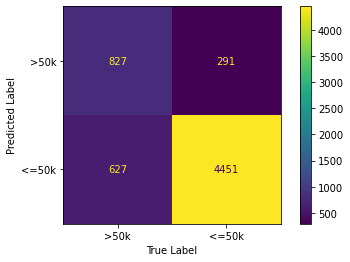

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,4))

ConfusionMatrixDisplay(confusion_matrix(predict,y_test,labels=[1,0]),
                       display_labels=[">50k","<=50k"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# columns used in the model (k columns)
features = all_models.best_estimator_.named_steps['fs']
features.get_support()

array([False, False, False, False, False, False,  True,  True,  True,
       False,  True, False,  True, False, False,  True,  True, False,
       False,  True, False, False, False,  True, False,  True, False,
       False, False, False, False,  True, False,  True,  True, False,
       False, False, False, False,  True, False, False, False, False,
        True, False, False])

In [ ]:
# All information is trackable going back in the Pipeline
# categorical columns
features_full = all_models.best_estimator_.named_steps['full_pipeline']
features_cat = features_full.get_params()["cat_pipeline"]
features_cat[2].get_feature_names()

array(['x0_ Private', 'x0_ Without-pay', 'x0_Govt_employees',
       'x0_Self_employed', 'x0_unknown', 'x1_ Assoc-voc', 'x1_ Bachelors',
       'x1_ Doctorate', 'x1_ Masters', 'x1_ Preschool', 'x1_ Prof-school',
       'x1_ Some-college', 'x1_HS-grad', 'x1_elementary_school',
       'x2_ Widowed', 'x2_Married', 'x2_Separated', 'x3_ Armed-Forces',
       'x3_ Craft-repair', 'x3_ Exec-managerial', 'x3_ Farming-fishing',
       'x3_ Handlers-cleaners', 'x3_ Machine-op-inspct',
       'x3_ Other-service', 'x3_ Priv-house-serv', 'x3_ Prof-specialty',
       'x3_ Protective-serv', 'x3_ Sales', 'x3_ Tech-support',
       'x3_ Transport-moving', 'x3_unknown', 'x4_ Not-in-family',
       'x4_ Other-relative', 'x4_ Own-child', 'x4_ Unmarried', 'x4_ Wife',
       'x5_ Asian-Pac-Islander', 'x5_ Black', 'x5_ Other', 'x5_ White',
       'x6_ Male', 'x7_non_usa'], dtype=object)

In [ ]:
features_full

FeatureUnion(transformer_list=[('cat_pipeline',
                                Pipeline(steps=[('cat_selector',
                                                 FeatureSelector(feature_names=['workclass',
                                                                                'education',
                                                                                'marital_status',
                                                                                'occupation',
                                                                                'relationship',
                                                                                'race',
                                                                                'sex',
                                                                                'native_country'])),
                                                ('cat_transformer',
                                                 CategoricalTransformer()),
                                                ('cat_encoder',
                                                 OneHotEncoder(drop='first',
                                                               sparse=False))])),
                               ('num_pipeline',
                                Pipeline(steps=[('num_selector',
                                                 FeatureSelector(feature_names=['age',
                                                                                'fnlwgt',
                                                                                'education_num',
                                                                                'capital_gain',
                                                                                'capital_loss',
                                                                                'hours_per_week'])),
                                                ('num_transformer',
                                                 NumericalTransformer())]))])

In [ ]:
# numerical columns
features_full.get_params()["num_pipeline"][1].get_feature_names()

['age',
 'fnlwgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week']

In [ ]:
all_columns = features_cat[2].get_feature_names().tolist() + features_full.get_params()["num_pipeline"][1].get_feature_names()
all_columns

['x0_ Private',
 'x0_ Without-pay',
 'x0_Govt_employees',
 'x0_Self_employed',
 'x0_unknown',
 'x1_ Assoc-voc',
 'x1_ Bachelors',
 'x1_ Doctorate',
 'x1_ Masters',
 'x1_ Preschool',
 'x1_ Prof-school',
 'x1_ Some-college',
 'x1_HS-grad',
 'x1_elementary_school',
 'x2_ Widowed',
 'x2_Married',
 'x2_Separated',
 'x3_ Armed-Forces',
 'x3_ Craft-repair',
 'x3_ Exec-managerial',
 'x3_ Farming-fishing',
 'x3_ Handlers-cleaners',
 'x3_ Machine-op-inspct',
 'x3_ Other-service',
 'x3_ Priv-house-serv',
 'x3_ Prof-specialty',
 'x3_ Protective-serv',
 'x3_ Sales',
 'x3_ Tech-support',
 'x3_ Transport-moving',
 'x3_unknown',
 'x4_ Not-in-family',
 'x4_ Other-relative',
 'x4_ Own-child',
 'x4_ Unmarried',
 'x4_ Wife',
 'x5_ Asian-Pac-Islander',
 'x5_ Black',
 'x5_ Other',
 'x5_ White',
 'x6_ Male',
 'x7_non_usa',
 'age',
 'fnlwgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week']

In [ ]:
selected_columns = [value for (value, filter) in zip(all_columns, features.get_support()) if filter]
selected_columns

['x1_ Bachelors',
 'x1_ Doctorate',
 'x1_ Masters',
 'x1_ Prof-school',
 'x1_HS-grad',
 'x2_Married',
 'x2_Separated',
 'x3_ Exec-managerial',
 'x3_ Other-service',
 'x3_ Prof-specialty',
 'x4_ Not-in-family',
 'x4_ Own-child',
 'x4_ Unmarried',
 'x6_ Male',
 'capital_gain']

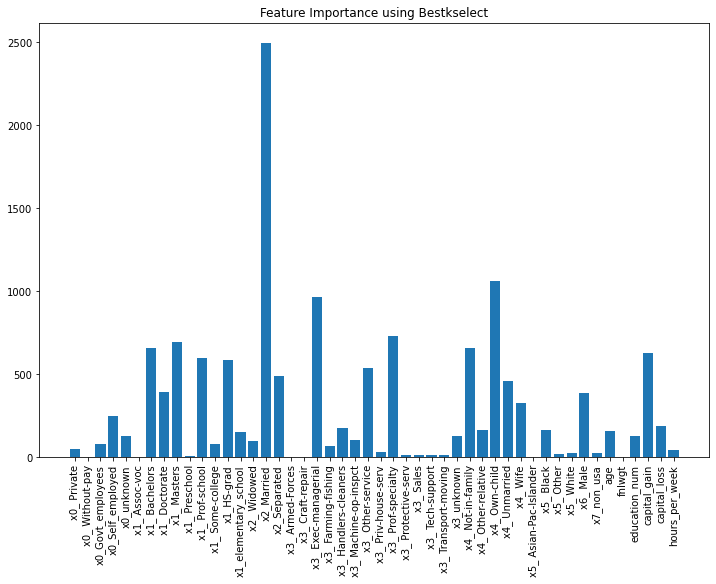

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

xticks = [x for x in range(len(features.scores_))] 
ax.bar(xticks, features.scores_)
ax.set_xticks(xticks)
ax.set_xticklabels(all_columns,rotation=90)
#ax.set_xticks(ticks=xticks, labels=all_columns,rotation=90,fontsize=15)
ax.set_title("Feature Importance using Bestkselect")
plt.show()

In [ ]:
classifier = all_models.best_estimator_.named_steps['clf']
classifier

RandomForestClassifier(max_leaf_nodes=128, n_estimators=400, random_state=15)

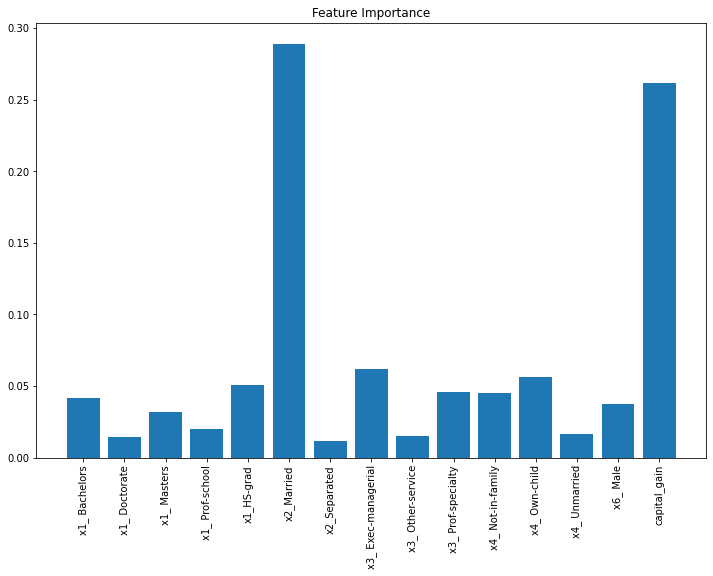

In [ ]:
classifier.feature_importances_.shape

fig, ax = plt.subplots(1,1,figsize=(12,8))

xticks = [x for x in range(len(classifier.feature_importances_))] 
ax.bar(xticks, classifier.feature_importances_)
ax.set_xticks(xticks)
ax.set_xticklabels(selected_columns,rotation=90)
#ax.set_xticks(ticks=xticks, labels=all_columns,rotation=90,fontsize=15)
ax.set_title("Feature Importance")
plt.show()

In [ ]:
# Save the model using joblib
with open('pipe.joblib', 'wb') as file:
  joblib.dump(all_models, file)

In [ ]:
# Under the production environment [joblib]
with open('pipe.joblib', 'rb') as file:
  model = joblib.load(file)

# final model
predict = model.predict(X_test)

In [ ]:
print(accuracy_score(y_test, predict))
print(classification_report(y_test,predict))

0.8518398967075532
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4742
           1       0.74      0.57      0.64      1454

    accuracy                           0.85      6196
   macro avg       0.81      0.75      0.77      6196
weighted avg       0.84      0.85      0.84      6196



### 2.4.8 Final Remarks

While the random forest algorithm is incredibly powerful, it isn't applicable to all tasks. The main **strengths** of a **Random Forest** are:

- **Very accurate predictions** - Random forests achieve near state-of-the-art performance on many machine learning tasks. Along with neural networks and gradient-boosted trees, they're typically one of the top-performing algorithms.
- **Resistance to overfitting** - Due to their construction, Random Forests are fairly resistant to overfitting. We still need to set and tweak parameters like **max_depth** though.

The main **weaknesses** of using a **Random Forest** are:

- **They're difficult to interpret** - Because we've averaging the results of many trees, it can be hard to figure out why a Random Forest is making predictions the way it is.
- **They take longer to create** - Making two trees takes twice as long as making one, making three takes three times as long, and so on. Fortunately, we can exploit multicore processors to parallelize tree construction. Scikit allows us to do this through the **n_jobs** parameter on [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). We'll discuss parallelization in greater detail later on.

Given these trade-offs, it makes sense to use Random Forests in situations where accuracy is of the utmost importance; being able to interpret or explain the decisions the model is making isn't key. In cases where time is of the essence or interpretability is important, a single decision tree may be a better choice.